In [1]:
import sys
import os

import pandas as pd
import sqlite3
# from datadings.tools import yield_threaded
from tqdm import tqdm

from Harmony.models import Harmony

# from Harmony.models.clip import CLIP_VITL16
# from Harmony.models.dinov2 import vit_large
import argparse

from Harmony import utils
import Harmony.models.vision_transformer as vits

import torch
import torchvision
import gzip
import json
from PIL import Image

C:\Users\Moham\AppData\Local\Temp\ipykernel_20144\2477414774.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\Moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
from pathlib import Path

def get_files_from_root(directory):
    p = Path(directory)
    return [file.stem for file in tqdm(p.glob('**/*')) if file.is_file()]

top_directory = "D:\data\YFCC15M\YFCC15M_extracted\data\images"
z = get_files_from_root(top_directory)

KeyboardInterrupt: 

In [37]:
import numpy as np
from Harmony.data.utils import SimpleTokenizer
from PIL import Image

def get_files_from_root(directory):
    f = []
    for root, dirs, files in tqdm(os.walk(directory)):
        for file in files:
            file_path = os.path.join(root, file)
            f.append(file_path.split(os.sep)[-1].split(".")[0])
    return f

class YFCC15M(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, tokneizer=SimpleTokenizer(), **kwargs):
        self.root = root
        
        files = get_files_from_root(self.root + os.sep + "images")
        self.df = pd.read_csv(root + os.sep + "yfcc15m.csv")
        indices = self.df['1'].isin(files)
        self.df = self.df[indices]
        
        self.image_captions = [tuple(x[2:]) for x in self.df.to_numpy()]
        self.transform = transform
        self.tokenizer = tokneizer
        print("Number of images loaded in YFCC15M are:", {self.__len__()})

    def __len__(self):
        return len(self.image_captions)

    def get_image_caption_pair(self, idx):
        item = self.image_captions[0]
        path = item[0]
        path = self.root + os.sep + "images" + os.sep + path[:3] + os.sep + path[3:6] + os.sep + path + ".jpg"
        image = Image.open(path).convert("RGB")
        caption = np.random.choice([item[1], item[2]])
        return image, caption


    def __getitem__(self, idx):
        image, caption = self.get_image_caption_pair(idx)
        if self.transform:
            image = self.transform(image)
        if self.tokenizer:
            caption = self.tokenizer(caption)
    
        return image, caption

In [38]:
r = YFCC15M(root="D:\data\YFCC15M\YFCC15M_extracted\data")

1372291it [03:21, 6817.98it/s]


Number of images loaded in YFCC15M are: {2165959}


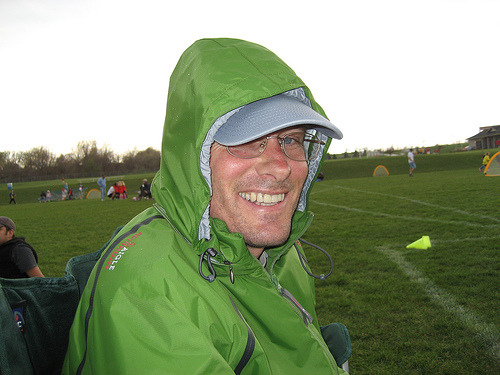

In [40]:
r[0][0]

In [27]:
ind = r.df['1'].isin(z)

In [28]:
ind

0            True
1            True
2            True
3            True
4            True
            ...  
14829391    False
14829392    False
14829393    False
14829394    False
14829395    False
Name: 1, Length: 14829396, dtype: bool

In [32]:
b = r.df[ind]

In [34]:
b = r.df[ind]

In [35]:
b

,Unnamed: 0,0,1,2,3
0,0,http://farm1.staticflickr.com/220/478637637_f2...,00156d23e1eaf8edaad4748a2cbd,Chilly soccer game,"Dad's a good sport specatator, keeping warm"
1,1,http://farm4.staticflickr.com/3157/2342279336_...,0013f5df6b77c1c61770a61d5d2687,Stinson Reliant Information,Information panel for the Stinson Reliant mail...
2,2,http://farm3.staticflickr.com/2010/2365135885_...,001dd37fa9ec4ec6c502e893b8476,"Nightfall Between Bridges, Brooklyn, NY",A panoramic shot of Manhattan between the Broo...
3,3,http://farm3.staticflickr.com/2389/2515710583_...,0019dcc1de5e66ddabec2c2790fb6f,First amphibious guest of the season!,Found this sweetie lounging on a lily pad in m...
4,4,http://farm4.staticflickr.com/3178/2635470994_...,0016c8879d709d7f9eae5ddff5ebcd,Birthday Weekend,One thing I learned this weekend was to never ...
...,...,...,...,...,...
2187129,2187129,http://farm3.staticflickr.com/2916/13923343541...,32a0ea699c2897492580f8e71256d19e,"Salt Lake County, Utah, Wasatch Hollow, Salt L...",Check out the related YouTube video here. - \n...
2187134,2187134,http://farm8.staticflickr.com/7003/13937328663...,32a0b0d2f3ba879a9dc483781b152b28,Barclays Center Arena - 20140419_1220,Barclays Center Arena\nAtlantic Yards\n6th and...
2187136,2187136,http://farm8.staticflickr.com/7348/13954790274...,32a11e7ba9e6dd474755aadbe92bd942,"Capitol Hill, District of Columbia, Washington...",Check out the related YouTube video here. - \n...
2187145,2187145,http://farm3.staticflickr.com/2919/14009565002...,32a266972a14b2f4a1a39721d9ab36da,Bermuda,Honeymoon in Bermuda at the Sonesta Beach Reso...


In [26]:
r.df['1'].isin(z)

0            True
1            True
2            True
3            True
4            True
            ...  
14829391    False
14829392    False
14829393    False
14829394    False
14829395    False
Name: 1, Length: 14829396, dtype: bool

In [24]:
b

(<PIL.Image.Image image mode=RGB size=500x375>,
 tensor([49406,  2639,   568,   320,   886,  2364,  1711,   527,  1962,   267,
          4873,  3616, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]))

In [23]:
len(b)

2

In [6]:
def apply_function_to_subfiles(directory):
    f = []
    for root, dirs, files in tqdm(os.walk(directory)):
        for file in files:
            file_path = os.path.join(root, file)
            f.append(file_path.split(os.sep)[-1].split(".")[0])
    return f

# Example usage
top_directory = "D:\data\YFCC15M\YFCC15M_extracted\data\images"
z = apply_function_to_subfiles(top_directory)

1372291it [03:20, 6831.67it/s]


In [21]:
len(z)

2165959

In [ ]:
r = "D:\data\YFCC15M\YFCC15M_extracted\data\images"
os.listdir(r)

In [ ]:
p = "D:/data/YFCC15M/yfcc15m.tsv"

In [ ]:
df = pd.read_csv(p, sep='\t', names=["head", "caption"])

In [ ]:
def combine_path(item):
    item = item.split("/")[-1]
    item = item.replace('_', '')
    return item

In [ ]:
f = df['head'].apply(combine_path)

In [ ]:
http://farm8.staticflickr.com/7072/13810813364_33e7e603ae.jpg

In [ ]:
df['head'].str.len().max()

In [ ]:
import pandas as pd
import os
import urllib
from pathlib import Path
from tqdm import tqdm
from Harmony.other.yfcc100m.yfcc100m.tools import load_metadata

In [ ]:
# with open('yfcc100m_dataset.txt') as f:
#     for l in tqdm(f.readlines()):
#         row = l.strip().split('\t')
#         if int(row[0]) in image_ids:
#             uncaptioned.append(int(row[0]))
#             if int(row[0]) in clip_ids:
#                 title = unquote(row[8]).replace('+', ' ')
#                 title = re.sub(cleanhtml, '', title)
#                 title = re.sub(cleanurl, '', title)

#                 desc = unquote(row[9]).replace('+', ' ')
#                 desc = re.sub(cleanhtml, '', desc)
#                 desc = re.sub(cleanurl, '', desc)
                
#                 captioned.append((int(row[0]), title, desc))

In [ ]:
meta_shards = os.listdir("D:/data/YFCC15M/meta")

df_list = []
for shard in tqdm(meta_shards):
    with gzip.open(Path("D:/data/YFCC15M/meta") / shard, 'rt', encoding='utf-8') as fp:
        for line in fp:
            df_list.append(json.loads(line))

In [ ]:
from urllib.parse import unquote
import re
cleanhtml = re.compile('<a.*?>|</a>|<b>|</b>|<i>|</i>')
cleanurl = re.compile('http\S+|www\S+')

In [ ]:
f = []
for d in tqdm(df_list):
    url = d['downloadurl']
    key = d['key']
    title = d['title']
    desc  = d['description']

    title = unquote(title).replace('+', ' ')
    title = re.sub(cleanhtml, '', title)
    title = re.sub(cleanurl, '', title)

    desc = unquote(desc).replace('+', ' ')
    desc = re.sub(cleanhtml, '', desc)
    desc = re.sub(cleanurl, '', desc)

    f.append((url, key, title, desc))

In [ ]:
d = pd.DataFrame(f)

In [ ]:
d.names = ["url", "name", "title", "caption"]

In [ ]:
d.to_csv("yfcc15m.csv")

In [ ]:
z = d[1]

In [ ]:
path = "C:\Users\Moham\Desktop\KAUST\results\t\checkpoint.pth"

In [ ]:
import os
import zipfile
zip_directory = "D:/data/YFCC15M/"
zips = [zip for zip in os.listdir("D:\data\YFCC15M") if zip[-4:] == ".zip"]
# zips = zips

In [ ]:
from urllib.parse import unquote_plus

encoded_str = "This+photo+was+taken+during+our+first+visit+to+Congaree+National+Park+in+June+2011.++It+was+fairly+dry%2C+so+areas+that+are+sometimes+underwater+were+dry.+Congaree+National+Park+preserves+the+largest+tract+of+old+growth+bottomland+hardwood+forest+left+in+the+United+States.+Located+in+South+Carolina%2C+the+22%2C000+acre+national+park+received+that+designation+in+2003+as+the+culmination+of+a+grassroots+campaign+which+had+started+in+1969.+The+lush+trees+growing+in+this+floodplain+forest+are+some+of+the+tallest+in+the+Eastern+U.S.%2C+forming+one+of+the+highest+natural+canopies+remaining+in+the+world.+The+Congaree+River+flows+through+the+park.+15%2C000+acres+%28or+about+70+percent+of+the+park%29+is+designated+wilderness+area.%0A%0AMost+visitors+to+the+park+walk+along+the+Boardwalk+Loop%2C+an+elevated+2.4+mile+walkway+through+the+swampy+environment+that+protects+delicate+fungi+and+plant+life+at+ground+level.%0A%0A%3Ca+href%3D%22http%3A%2F%2Fen.wikipedia.org%2Fwiki%2FCongaree_National_Park%22+rel%3D%22nofollow%22%3Een.wikipedia.org%2Fwiki%2FCongaree_National_Park%3C%2Fa%3E%0A%0A%3Ca+href%3D%22http%3A%2F%2Fen.wikipedia.org%2Fwiki%2FWikipedia%3AText_of_Creative_Commons_Attribution-ShareAlike_3.0_Unported_License%22+rel%3D%22nofollow%22%3Een.wikipedia.org%2Fwiki%2FWikipedia%3AText_of_Creative_Commons_...%3C%2Fa%3E"
decoded_str = unquote_plus(encoded_str)

In [ ]:
decoded_str

In [ ]:
image_paths = []

def list_images_in_zip(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # List all contents and filter for image files
        image_files = [item for item in zip_ref.namelist() if item.lower().endswith(('.jpg'))]
    return image_files

for zip_file in tqdm(zips):
    zip_path = os.path.join(zip_directory, zip_file)
    image_paths.extend(list_images_in_zip(zip_path))

In [ ]:
len(image_paths)

In [ ]:
len(image_paths)

In [ ]:
def estimate_unzipped_size(zip_path):
    total_size = 0
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for info in zip_ref.infolist():
            total_size += info.file_size  # Use `file_size` for uncompressed size
    return total_size

all_size = 0

for zip_file in zips:
    zip_path = os.path.join(zip_directory, zip_file)
    estimated_size = estimate_unzipped_size(zip_path)
    all_size += estimated_size
    # print(f"Estimated size for {zip_file} when unzipped: {estimated_size} bytes")

In [ ]:
all_size

In [ ]:
total_aggregated_size_gb = all_size / (1024**3)

In [ ]:
total_aggregated_size_gb

In [ ]:
from itertools import chain, combinations, permutations

def power_set_permutations(iterable):
    s = list(iterable)
    return list("_".join(t) for t in chain.from_iterable(permutations(t) for t in chain.from_iterable(combinations(s, r) for r in range(len(s)+1))))

# Test the function
print(power_set_permutations(['ibot', 'dino', 'mae']))

In [ ]:
it_ = torch.load("ibot_t.pth")
ht  = torch.load("harmony_t.pth")

In [ ]:
is_ = torch.load("ibot_s.pth")
hs  = torch.load("harmony_s.pth")

In [ ]:
is_same = True

# params1 = is_
params2 = hs

params1 = it_
# params2 = ht

for key in params1:
    if key in params2:
        if not torch.equal(params1[key], params2[key]):
            print(f"Difference found in parameter: {key}")
            is_same = False
    else:
        print(f"Parameter {key} not found in the second model.")
        is_same = False

for key in params2:
    if key not in params1:
        print(f"Parameter {key} not found in the first model.")
        is_same = False

if is_same:
    print("The parameters of the two models are exactly the same.")


In [ ]:
it_.values(

)

In [ ]:
hs.values()

In [ ]:
it_

In [ ]:
ht

In [ ]:
ht.values() == it_.values()

In [ ]:
args = argparse.Namespace(arch='vit_small', batch_size_per_gpu=1, clip_grad=3.0, data='CC3M:/mnt/d/data/CC3M/cc3m/', dist_url='env://', drop_path_rate=0.1, epochs=100, freeze_last_layer=1, global_crops_scale=(0.4, 1.0), gpu=0, local_crops_number=8, local_crops_scale=(0.05, 0.4), local_rank=0, lr=0.0005, min_lr=1e-06, momentum_teacher=0.996, norm_last_layer=True, num_workers=10, objective='dino', optimizer='adamw', out_dim=65536, output_dir='/mnt/c/Users/Moham/Desktop/KAUST/results', patch_size=16, rank=0, saveckp_freq=20, seed=0, teacher_temp=0.04, use_bn_in_head=False, use_fp16=True, warmup_epochs=10, warmup_teacher_temp=0.04, warmup_teacher_temp_epochs=0, weight_decay=0.04, weight_decay_end=0.4, world_size=1)

In [ ]:
checkpoint = torch.load(r"/mnt/c/Users/Moham/Desktop/KAUST/results/checkpoint0000.pth", map_location="cpu")

In [ ]:
# utils.init_distributed_mode(args)
# utils.fix_random_seeds(args.seed)

# model = Harmony(args=args)

model = vits.__dict__[args.arch](patch_size=args.patch_size, num_classes=0)

In [ ]:
print(len(checkpoint['main_vit'].keys()))

In [ ]:
checkpoint_key = "main_vit"
state_dict = torch.load(r"/mnt/c/Users/Moham/Desktop/KAUST/results/checkpoint0000.pth", map_location="cpu")

if checkpoint_key is not None and checkpoint_key in state_dict:
    print(f"Take key {checkpoint_key} in provided checkpoint dict")
    state_dict = state_dict[checkpoint_key]
# remove `module.` prefix
# state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# # remove `backbone.` prefix induced by multicrop wrapper
# state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
msg = model.load_state_dict(state_dict, strict=False)

In [ ]:
msg

In [ ]:
msg

In [ ]:
print([i for i in model.parameters()])

In [ ]:
checkpoint['model']

In [ ]:
checkpoint['teacher']

In [ ]:
pretrained_weights = "/mnt/c/Users/Moham/Desktop/KAUST/results/checkpoint.pth"
checkpoint_key = "model"
state_dict = torch.load(pretrained_weights, map_location="cpu")
if checkpoint_key is not None and checkpoint_key in state_dict:
    print(f"Take key {checkpoint_key} in provided checkpoint dict")
    state_dict = state_dict[checkpoint_key]
msg = model.load_state_dict(state_dict, strict=False)
print('Pretrained weights found at {} and loaded with msg: {}'.format(pretrained_weights, msg))

In [ ]:
model.discriminative_path.teacher

In [ ]:
model.discriminative_path.teacher.backbone

In [ ]:
for p in model.discriminative_path.teacher.backbone.parameters():
    print(p)

In [ ]:
from torchvision import transforms as pth_transforms

# train_transform = pth_transforms.Compose([
#     pth_transforms.RandomResizedCrop(224),
#     pth_transforms.RandomHorizontalFlip(),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])


train_data = torchvision.datasets.ImageFolder("/mnt/e/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train")

data = torch.utils.data.DataLoader(train_data, batch_size=1)

In [ ]:
print(data.dataset[445245])

In [ ]:
data.dataset[1277363]

In [ ]:
l = 0
for i in range(data.__len__()):
    r = data.dataset[i]
    print("class:", r[1])
    print("image:", r[0])
    print(i)

In [ ]:
import os
file_path = os.path.realpath(__file__)

In [ ]:
train_data[0][1]

In [ ]:
from torchvision import datasets
from PIL import Image
import os

class ImageNet(torch.utils.data.Dataset):
    def __init__(self, root, split="train", transform=None, **kwargs):
        self.root = root
        self.transform = transform
        self.split = split

        if split == "train":
            self.data = datasets.ImageFolder(root, transform=transform)
        elif split == "val":
            self.images =  os.listdir(self.root)
            self.image_paths = [os.path.join(self.root, image) for image in self.images]
            self.labels = pd.read_csv("./Harmony/data/meta/imagenet_val_labels.csv")

    def __len__(self):
        if self.split == "train":
            return self.data.__len__()
        else:
            return len(self.images)

    def get_image_target(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image_name = self.images[idx].split('.')[0]
        label = self.labels[self.labels['ImageId'] == image_name]['PredictionString'].item()
        return image, label

    def __getitem__(self, idx):

        if self.split == "train":
            return self.data[idx][0], self.data[idx][1]
        
        image, target = self.get_image_target(idx)
        
        if self.transform:
            image = self.transform(image)

        return image, target

In [ ]:
data = ImageNet(root="/mnt/e/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/", split="val")

In [ ]:
for i, t in data:
    print(t)

In [ ]:
import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block
from vision_transformer import Block

from utils import get_2d_sincos_pos_embed

class GenerativePath(nn.Module):
    def __init__(self, image_encoder, patch_size=16, in_chans=3,
                embed_dim=1024, decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                mlp_ratio=4, norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.norm_pix_loss = norm_pix_loss
        self.image_encoder = image_encoder
        self.patch_embed = image_encoder.patch_embed
        num_patches = self.image_encoder.patch_embed.num_patches

        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch

    def initialize_deocder_weights(self):
        
        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        torch.nn.init.normal_(self.mask_token, std=.02)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        print(self.patch_embed.patch_size)
        p = self.patch_embed.patch_size
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.image_encoder.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.image_encoder.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.image_encoder.cls_token + self.image_encoder.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.image_encoder.blocks:
            x = blk(x)
        x = self.image_encoder.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask

In [ ]:
s = GenerativePath(image_encoder=model.image_encoder, embed_dim=384).cuda()
r = torch.rand([1, 3, 224, 224]).cuda()

In [ ]:
l, p, m = s(r)

In [ ]:
clip = CLIP_VITL16()

In [ ]:
import torch

In [ ]:
import sys
import os

In [ ]:
a = [f for f in os.scandir("/mnt/d/data/CC3M/cc3m/") if f.is_dir()]

In [ ]:
def save_images_in_folders(folders):
    images_paths = []
    for folder in folders:
        for filename in os.listdir(folder):
            if os.path.isfile(os.path.join(folder, filename)):

In [ ]:
paths = save_images_in_folders(a)

In [ ]:
import os
from PIL import Image
from Harmony.data.utils import SimpleTokenizer

def save_image_captions_from_folders(folders, root):
    images_paths  = []
    captions_path = []
    for folder in folders:
        for filename in os.listdir(folder):
            if ".jpg" in filename or ".png" in filename:
                images_paths.append(root + os.sep + folder.name + os.sep + filename)
            elif ".txt" in filename:
                captions_path.append(root + os.sep + folder.name + os.sep + filename)
    return images_paths, captions_path

class CC3M(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, tokneizer=SimpleTokenizer(), **kwargs):
        self.root = root
        self.folders =  [f for f in os.scandir(root) if f.is_dir()]
        self.images, self.captions = save_image_captions_from_folders(self.folders, self.root)
        self.images.sort(), self.captions.sort() # sort to make sure there is correspondence
        self.transform = transform
        self.tokenizer = tokneizer

        # self.images = self.images[:10]
        # self.captions = self.captions[:10]

        assert len(self.captions) == len(self.images)
        print("Number of images loaded in CC3M are:", {self.__len__()})

    def __len__(self):
        return len(self.images)

    def get_image_caption_pair(self, idx):
        print(self.images[idx])
        print(self.captions[idx])
        image = Image.open(self.images[idx]).convert("RGB")
        caption_file = open(self.captions[idx])
        caption = caption_file.read()
        caption_file.close()

        return image, caption


    def __getitem__(self, idx):
        image, caption = self.get_image_caption_pair(idx)
        if self.transform:
            image = self.transform(image)
        if self.tokenizer:
            caption = self.tokenizer(caption)
    
        return image, caption

In [ ]:
a = CC3M(root="D:\data\CC3M\cc3m")

In [ ]:
i, t = a[100000]

In [ ]:
import tarfile

# Open the tar file
tar = tarfile.open(r'D:\data\CC3M\cc3m\00000.tar')

# Loop over each member
for member in tar.getmembers():
    print(member)
    # Extract each file as a file object
    f = tar.extractfile(member)
    if f is not None:
        # Read the contents
        content = f.read()

# Close the tar file
tar.close()
